In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# convert text to lowercase 
def text_lowercase(text):
    return text.lower()

In [ ]:
# remove numbers or convert the numbers into their textual representations 
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

In [ ]:
# remove punctuations
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [ ]:
# To remove leading and ending spaces
def remove_whitespace(text):
    return  " ".join(text.strip().split())

In [ ]:
# "Stop words" are the most common words in a language like "the", "a", "on", "is", "all", etc. 
# These words do not carry important meaning so that they can safely be removed 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
  
# remove stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text

In [ ]:
# Remove short words
def remove_short_words(l_token):
    return [word for word in l_token if len(word)>3]

In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer = PorterStemmer()
  
# stem words in the list of tokenised words
def stem_words(text):
    if isinstance(text, list):
        stems = [stemmer.stem(word) for word in text]
    else:
        word_tokens = word_tokenize(text)
        stems = [stemmer.stem(word) for word in word_tokens]
    return stems

In [ ]:
!pip3 install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 3.9 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=30dbed1ce44332d1eb288f34e3b5102f74b99bdfc201dd00ca9eebbc1e1bcbd8
  Stored in directory: /root/.cache/pip/wheels/31/8c/a0/24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
Successfully built pyLDAvis


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
filename = '/content/drive/MyDrive/[HCDS] A4 - Final Project /Musk_extracted_tweets_2022'

df_tweets = pd.read_csv(filename)
df_tweets

,Unnamed: 0,tweet_id,screen_name,text,timestamp,conversation_id
0,0,1593551192176500736,elonmusk,@lionxmah @folha ?,2,1590384919829962752
1,1,1593541440671338496,elonmusk,@AOC You’re welcome,2022-11-18 09:47:40+00:00,1593399168764190720
2,2,1593535742285750272,elonmusk,@WholeMarsBlog Record numbers of users are log...,2022-11-18 09:25:02+00:00,1593315850546618368
3,3,1593528527873200130,elonmusk,@piersmorgan Seriously,2022-11-18 08:56:22+00:00,1593521238915403776
4,4,1593494261038649344,elonmusk,https://t.co/JU073T756X,2022-11-18 06:40:12+00:00,1593494261038649344
...,...,...,...,...,...,...
3194,3194,1509474644306411522,elonmusk,@teslaownersSV @PPathole @SpaceX Will take of it,2022-03-31 10:16:14+00:00,1508967431548506112
3195,3195,1509416977449857029,elonmusk,@teslaownersSV @SpaceX You may be in an area t...,2022-03-31 06:27:05+00:00,1508967431548506112
3196,3196,1509308717094916101,elonmusk,@BillyM2k 🤣,2022-03-30 23:16:54+00:00,1509304553811841027
3197,3197,1509087321685209088,elonmusk,@JohnnaCrider1 Ok,2022-03-30 08:37:09+00:00,1508488978965614593


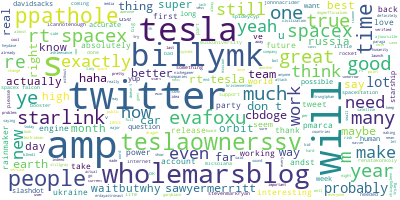

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_tweets["text"].apply(text_lowercase).apply(remove_numbers).apply(remove_punctuation).apply(remove_whitespace)))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, max_font_size=40, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
data = df_tweets['text'].dropna().values.tolist()
preprocessed_custom = df_tweets['text'].dropna().apply(text_lowercase).apply(remove_numbers).apply(remove_punctuation).apply(remove_whitespace).apply(remove_stopwords).apply(remove_short_words).apply(stem_words).values.tolist()
preprocessed_simple = list(sent_to_words(data))
preprocessed_custom[:1]

[['lionxmah', 'folha']]

In [ ]:
# Create Dictionary
id2word_custom = corpora.Dictionary(preprocessed_custom)

# Create Corpus
texts_custom = preprocessed_custom

# Term Document Frequency
corpus_custom = [id2word_custom.doc2bow(text) for text in texts_custom]

# View
print(corpus_custom[:1])

[[(0, 1), (1, 1)]]


In [ ]:
# Create Dictionary
id2word_simple = corpora.Dictionary(preprocessed_simple)

# Create Corpus
texts_simple = preprocessed_simple

# Term Document Frequency
corpus_simple = [id2word_simple.doc2bow(text) for text in texts_simple]

# View
print(corpus_simple[:1])

[[(0, 1), (1, 1)]]


In [ ]:
# Build LDA model
lda_model_custom = gensim.models.ldamodel.LdaModel(corpus=corpus_custom,
                                                   id2word=id2word_custom,
                                                   num_topics=10, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)

In [ ]:
# Build LDA model
lda_model_simple = gensim.models.ldamodel.LdaModel(corpus=corpus_simple,
                                                   id2word=id2word_simple,
                                                   num_topics=10, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)

In [ ]:
pprint(lda_model_custom.print_topics())

[(0,
  '0.043*"would" + 0.025*"like" + 0.024*"human" + 0.023*"think" + '
  '0.021*"teslarati" + 0.020*"waitbutwhi" + 0.017*"real" + 0.015*"much" + '
  '0.015*"johnnacrid" + 0.012*"residentspong"'),
 (1,
  '0.062*"teslaownerssv" + 0.039*"pmarca" + 0.022*"yeah" + 0.020*"also" + '
  '0.016*"love" + 0.016*"month" + 0.015*"watch" + 0.013*"talk" + 0.012*"futur" '
  '+ 0.011*"absolut"'),
 (2,
  '0.071*"wholemarsblog" + 0.017*"account" + 0.016*"user" + 0.016*"say" + '
  '0.016*"want" + 0.014*"statsfe" + 0.014*"icannotenough" + 0.013*"must" + '
  '0.012*"pleas" + 0.012*"includ"'),
 (3,
  '0.103*"twitter" + 0.069*"ppathol" + 0.039*"time" + 0.020*"team" + '
  '0.019*"evafoxu" + 0.016*"still" + 0.013*"better" + 0.011*"paraga" + '
  '0.011*"open" + 0.010*"tri"'),
 (4,
  '0.033*"work" + 0.031*"even" + 0.030*"true" + 0.025*"need" + 0.016*"improv" '
  '+ 0.014*"speech" + 0.014*"less" + 0.014*"use" + 0.012*"free" + '
  '0.010*"peac"'),
 (5,
  '0.079*"spacex" + 0.040*"peopl" + 0.024*"great" + 0.019*"fal

In [ ]:
pprint(lda_model_simple.print_topics())

[(0,
  '0.049*"wholemarsblog" + 0.020*"think" + 0.020*"slashdot" + 0.020*"yeah" + '
  '0.018*"probably" + 0.014*"company" + 0.013*"engineers_feed" + 0.013*"does" '
  '+ 0.011*"rainmaker" + 0.011*"actually"'),
 (1,
  '0.150*"co" + 0.147*"https" + 0.036*"should" + 0.029*"good" + '
  '0.009*"stats_feed" + 0.009*"something" + 0.008*"watch" + 0.008*"absolutely" '
  '+ 0.007*"let" + 0.006*"kristennetten"'),
 (2,
  '0.061*"and" + 0.026*"my" + 0.024*"what" + 0.017*"first" + 0.015*"so" + '
  '0.015*"right" + 0.014*"too" + 0.014*"haha" + 0.012*"most" + 0.012*"also"'),
 (3,
  '0.075*"tesla" + 0.046*"rt" + 0.028*"pmarca" + 0.016*"up" + 0.014*"woonomic" '
  '+ 0.014*"vaibhavsisinty" + 0.011*"those" + 0.011*"day" + 0.009*"ok" + '
  '0.009*"free"'),
 (4,
  '0.072*"spacex" + 0.022*"much" + 0.018*"launch" + 0.018*"falcon" + '
  '0.017*"some" + 0.016*"erdayastronaut" + 0.016*"space_station" + '
  '0.015*"dragon" + 0.012*"astronauts" + 0.012*"ax"'),
 (5,
  '0.028*"yes" + 0.026*"true" + 0.024*"exactly" + 

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_custom = pyLDAvis.gensim.prepare(lda_model_custom, corpus_custom, id2word_custom, sort_topics=False)
pyLDAvis.display(vis_custom)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_simple = pyLDAvis.gensim.prepare(lda_model_simple, corpus_simple, id2word_simple, sort_topics=False)
pyLDAvis.display(vis_simple)